# Analysing POIs in Leisure Walk Description Dataset

Loading the walkingmap dataset, download OSM POIs and annotate the POI dataset.

Using topic modelling to discover different types of POIs in leisure walk description dataset.

## Setup

Loading libraries and models

In [1]:
# working with files
import os.path
# sys
import sys

# warning off
import warnings
# IO
import json
# calling Webservices
import requests
# systematic thread stops for polite crawling
import time

# set random seed for reproducibility of results
from umap import UMAP

# dataframe 
import numpy as np
import pandas as pd
import geopandas as gpd

# geocoding
from geopy.geocoders import Nominatim

# getting data from OSM
import osmnx as ox

# topic modelling
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired

# nlp
from sentence_transformers import SentenceTransformer, util
import spacy
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt

# logging
from loguru import logger

# set logger level
logger.remove(0)
logger.add(sys.stderr, level="INFO")

warnings.filterwarnings("ignore")

# en_core_web_lg must be downloaded, if not run: 'python -m spacy download en_core_web_lg' first!
nlp = spacy.load('en_core_web_lg')

umap_model = UMAP(random_state=42)

stopword_removal = False

## Dataset

Reading the dataset crawled from WalkingMap website.

In [2]:
with open('dataset/walkingmaps.json', 'r', encoding='utf-8') as fp:
    dataset = json.load(fp)

In [3]:
logger.debug(f'an example record in dataset: {dataset[1]}')
logger.info(f'structure of records in dataset: {dataset[1].keys()}')

2025-01-25 20:16:41.546 | INFO     | __main__:<module>:2 - structure of records in dataset: dict_keys(['markers', 'pathDetails', 'pois', 'title', 'description'])


### Dataset Transformation

Aim: Transforming the dataset into pandas and geopandas dataframes, with a focus on POIs

In [4]:
counter = 0
total = 0
for record in dataset:
    if 'pois' in record.keys() and len(record['pois']) > 0:
        counter+=1
        total += len(record['pois'])
logger.info('records: {0} total POIs: {1} - average per record: {2}'.format(counter, total, round(total/counter)))

2025-01-25 20:16:59.104 | INFO     | __main__:<module>:7 - records: 386 total POIs: 4392 - average per record: 11


In [5]:
import statistics 

verbal_descriptions = []
poi_descriptions = []
for record in dataset:
    if 'pois' in record.keys() and len(record['pois']) > 0:
        vb = record['title']+' '+record['description']
        verbal_descriptions.append(vb)
        for poi in record['pois']:
            pvb = poi['title']+' '+poi['summary']
            poi_descriptions.append(pvb)

wc_vb = [len(vb.split(' ')) for vb in verbal_descriptions]
logger.info(f'word count verbal description \n\t- average: {int(statistics.mean(wc_vb))} - median: {statistics.median(wc_vb)} - min: {min(wc_vb)} - max: {max(wc_vb)}')
wc_pvb = [len(pvb.split(' ')) for pvb in poi_descriptions]
logger.info(f'word count POI verbal description \n\t- average: {int(statistics.mean(wc_pvb))} - median: {statistics.median(wc_pvb)} - min: {min(wc_pvb)} - max: {max(wc_pvb)}')
cc_vb = [len(vb) for vb in verbal_descriptions]
logger.info(f'character count verbal description \n\t- average: {int(statistics.mean(cc_vb))} - median: {statistics.median(cc_vb)} - min: {min(cc_vb)} - max: {max(cc_vb)}')
cc_pvb = [len(pvb) for pvb in poi_descriptions]
logger.info(f'character count POI verbal description \n\t- average: {int(statistics.mean(cc_pvb))} - median: {statistics.median(cc_pvb)} - min: {min(cc_pvb)} - max: {max(cc_pvb)}')

2025-01-25 20:17:03.005 | INFO     | __main__:<module>:14 - word count verbal description 
	- average: 181 - median: 130.0 - min: 7 - max: 540
2025-01-25 20:17:03.017 | INFO     | __main__:<module>:16 - word count POI verbal description 
	- average: 22 - median: 23.0 - min: 2 - max: 116
2025-01-25 20:17:03.018 | INFO     | __main__:<module>:18 - character count verbal description 
	- average: 1062 - median: 764.0 - min: 43 - max: 3052
2025-01-25 20:17:03.021 | INFO     | __main__:<module>:20 - character count POI verbal description 
	- average: 130 - median: 127.0 - min: 11 - max: 296


In [6]:
data_structure = {'record_title':[], 'record_description':[], 'poi_title':[], 'poi_summary':[], 'latitude': [], 'longitude': []}
for record in dataset:
    if 'pois' in record.keys() and len(record['pois']) > 0:
        for poi in record['pois']:
            data_structure['record_title'].append(record['title'])
            data_structure['record_description'].append(record['description'])
            data_structure['poi_title'].append(poi['title'])
            data_structure['poi_summary'].append(poi['summary'])
            data_structure['latitude'].append(poi['lat'])
            data_structure['longitude'].append(poi['lng'])

In [7]:
df = pd.DataFrame(data_structure)

gdf = gpd.GeoDataFrame(df[['poi_title', 'poi_summary', 'latitude', 'longitude']], geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

In [8]:
gdf.head()

poi_title  \
0  Fairhaven Surf Life Saving Club   
1                       Beach walk   
2                       Rock pools   
3                       Sand dunes   
4                  Painkalac Creek   

                                         poi_summary   latitude   longitude  \
0  Fairhaven is a well known surf beach. The beac... -38.468759  144.084459   
1  From Sprout Creek, Eastern View, Moggs Creek, ... -38.468542  144.089693   
2  See what sort of shells and stones you can col... -38.468459  144.092420   
3  The beautiful rolling sand dunes shape the bea... -38.468418  144.095318   
4  The creek separates Aireys Inlet from Fairhave... -38.468390  144.097312   

                      geometry  
0  POINT (144.08446 -38.46876)  
1  POINT (144.08969 -38.46854)  
2  POINT (144.09242 -38.46846)  
3  POINT (144.09532 -38.46842)  
4  POINT (144.09731 -38.46839)

In [9]:
df.head()

record_title  \
0  Fairhaven to Aireys Inlet Walk created by tedm...   
1  Fairhaven to Aireys Inlet Walk created by tedm...   
2  Fairhaven to Aireys Inlet Walk created by tedm...   
3  Fairhaven to Aireys Inlet Walk created by tedm...   
4  Fairhaven to Aireys Inlet Walk created by tedm...   

                                  record_description  \
0  Apart from the points of interested listed, he...   
1  Apart from the points of interested listed, he...   
2  Apart from the points of interested listed, he...   
3  Apart from the points of interested listed, he...   
4  Apart from the points of interested listed, he...   

                         poi_title  \
0  Fairhaven Surf Life Saving Club   
1                       Beach walk   
2                       Rock pools   
3                       Sand dunes   
4                  Painkalac Creek   

                                         poi_summary   latitude   longitude  
0  Fairhaven is a well known surf beach. The beac... -38.468759  144.084459  
1  From Sprout Creek, Eastern View, Moggs Creek, ... -38.468542  144.089693  
2  See what sort of shells and stones you can col... -38.468459  144.092420  
3  The beautiful rolling sand dunes shape the bea... -38.468418  144.095318  
4  The creek separates Aireys Inlet from Fairhave... -38.468390  144.097312

## Topic Modelling - Raw Inputs

**Aim**: Findings topics describing the POIs using BERT embeddings

**Approach**: Using raw textual description (title + summary) and feed it BERTopic for categorisation. Manunally investigating the categories to find out the categories are coherent and meaningful.

In [10]:
gdf['description'] = gdf['poi_title']+': '+gdf['poi_summary']

In [11]:
def remove_stopwords(row):
    return ' '.join([w for w in row['description'].split() if w.lower() not in stopwords.words('english')])

In [12]:
if stopword_removal:
    gdf['description'] = gdf.apply(remove_stopwords, axis=1)

In [13]:
gdf.head()

poi_title  \
0  Fairhaven Surf Life Saving Club   
1                       Beach walk   
2                       Rock pools   
3                       Sand dunes   
4                  Painkalac Creek   

                                         poi_summary   latitude   longitude  \
0  Fairhaven is a well known surf beach. The beac... -38.468759  144.084459   
1  From Sprout Creek, Eastern View, Moggs Creek, ... -38.468542  144.089693   
2  See what sort of shells and stones you can col... -38.468459  144.092420   
3  The beautiful rolling sand dunes shape the bea... -38.468418  144.095318   
4  The creek separates Aireys Inlet from Fairhave... -38.468390  144.097312   

                      geometry  \
0  POINT (144.08446 -38.46876)   
1  POINT (144.08969 -38.46854)   
2  POINT (144.09242 -38.46846)   
3  POINT (144.09532 -38.46842)   
4  POINT (144.09731 -38.46839)   

                                         description  
0  Fairhaven Surf Life Saving Club: Fairhaven is ...  
1  Beach walk: From Sprout Creek, Eastern View, M...  
2  Rock pools: See what sort of shells and stones...  
3  Sand dunes: The beautiful rolling sand dunes s...  
4  Painkalac Creek: The creek separates Aireys In...

In [14]:
docs = list(gdf['description'])
raw_model_path = 'outputs/model/raw_poi_descriptions'

overwrite = False
already_saved = False
if os.path.isfile(raw_model_path) and not overwrite:
    logger.info('model found in outputs folder')
    already_saved = True
    topic_model = BERTopic.load(raw_model_path)
    topics, probs = topic_model.topics_, topic_model.probabilities_
    logger.info(f'model is loaded from {raw_model_path}')
else:
    logger.info(f'model not found, will be created...')
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    topic_model = BERTopic(umap_model=umap_model, ctfidf_model=ctfidf_model)
    topics, probs = topic_model.fit_transform(docs)
    topic_model.save(raw_model_path, serialization='pickle')
    logger.info(f'model saved in {raw_model_path}')

2025-01-25 20:17:24.355 | INFO     | __main__:<module>:7 - model found in outputs folder
2025-01-25 20:17:26.206 | INFO     | __main__:<module>:11 - model is loaded from outputs/model/raw_poi_descriptions


In [15]:
topic_model.get_topic_info().head()

Topic  Count                                   Name  \
0     -1   1651                  -1_path_road_car_hall   
1      0    392            0_ducks_bird_birds_wetlands   
2      1    166          1_sculpture_mural_art_artwork   
3      2    147                  2_beach_bay_tide_surf   
4      3    111  3_melbourne_federation_wharf_flinders   

                                      Representation  \
0  [path, road, car, hall, continue, start, track...   
1  [ducks, bird, birds, wetlands, wetland, birdli...   
2  [sculpture, mural, art, artwork, wall, artists...   
3  [beach, bay, tide, surf, sand, tidal, swimming...   
4  [melbourne, federation, wharf, flinders, squar...   

                                 Representative_Docs  
0  [Business in the bridge: The pedestrian path e...  
1  [Baxters Wetland and bird hide : Nesting boxe...  
2  [9. Mural, Civic Hall/Library Car Park, off Ma...  
3  [Beach walkers: If the tide is out, walking al...  
4  [2nd Lighthouse: The tower used to show a fixe...

In [16]:
experiment_name = 'raw-poi'

intertopic_distance_map_html_path = f'outputs/figure/intertopic-dmap-{experiment_name}.html'
intertopic_distance_map_image_path = f'outputs/figure/intertopic-dmap-{experiment_name}.png'

topic_hierarchy_html_path = f'outputs/figure/topic-hierarchy-{experiment_name}.html'
topic_hierarchy_image_path = f'outputs/figure/topic-hierarchy-{experiment_name}.png'

detailed_topic_hierarchy_html_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.html'
detailed_topic_hierarchy_image_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.png'

barchart_html_path = f'outputs/figure/barchart-{experiment_name}.html'
barchart_image_path = f'outputs/figure/barchart-{experiment_name}.png'

heatmap_html_path = f'outputs/figure/heatmap-{experiment_name}.html'
heatmap_image_path = f'outputs/figure/heatmap-{experiment_name}.png'

2025-01-25 20:17:33.663 | INFO     | __main__:<module>:4 - figures already saved in HTML and image formats


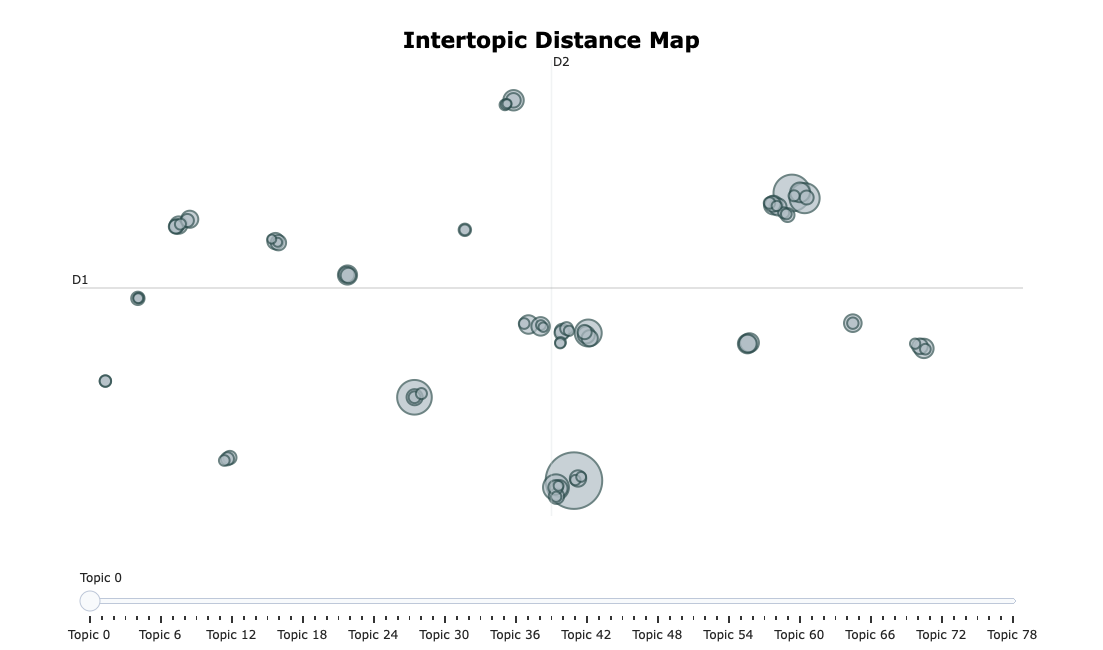

In [17]:
fig = topic_model.visualize_topics()

if not overwrite and os.path.isfile(intertopic_distance_map_html_path):
    logger.info('figures already saved in HTML and image formats')
else:
    fig.write_html(intertopic_distance_map_html_path)
    fig.write_image(intertopic_distance_map_image_path)
    logger.info(f'figures saved in: \n\t{intertopic_distance_map_html_path}\n\t{intertopic_distance_map_image_path}')

fig

2025-01-25 20:17:33.846 | INFO     | __main__:<module>:3 - figure is already saved in HTML and image format


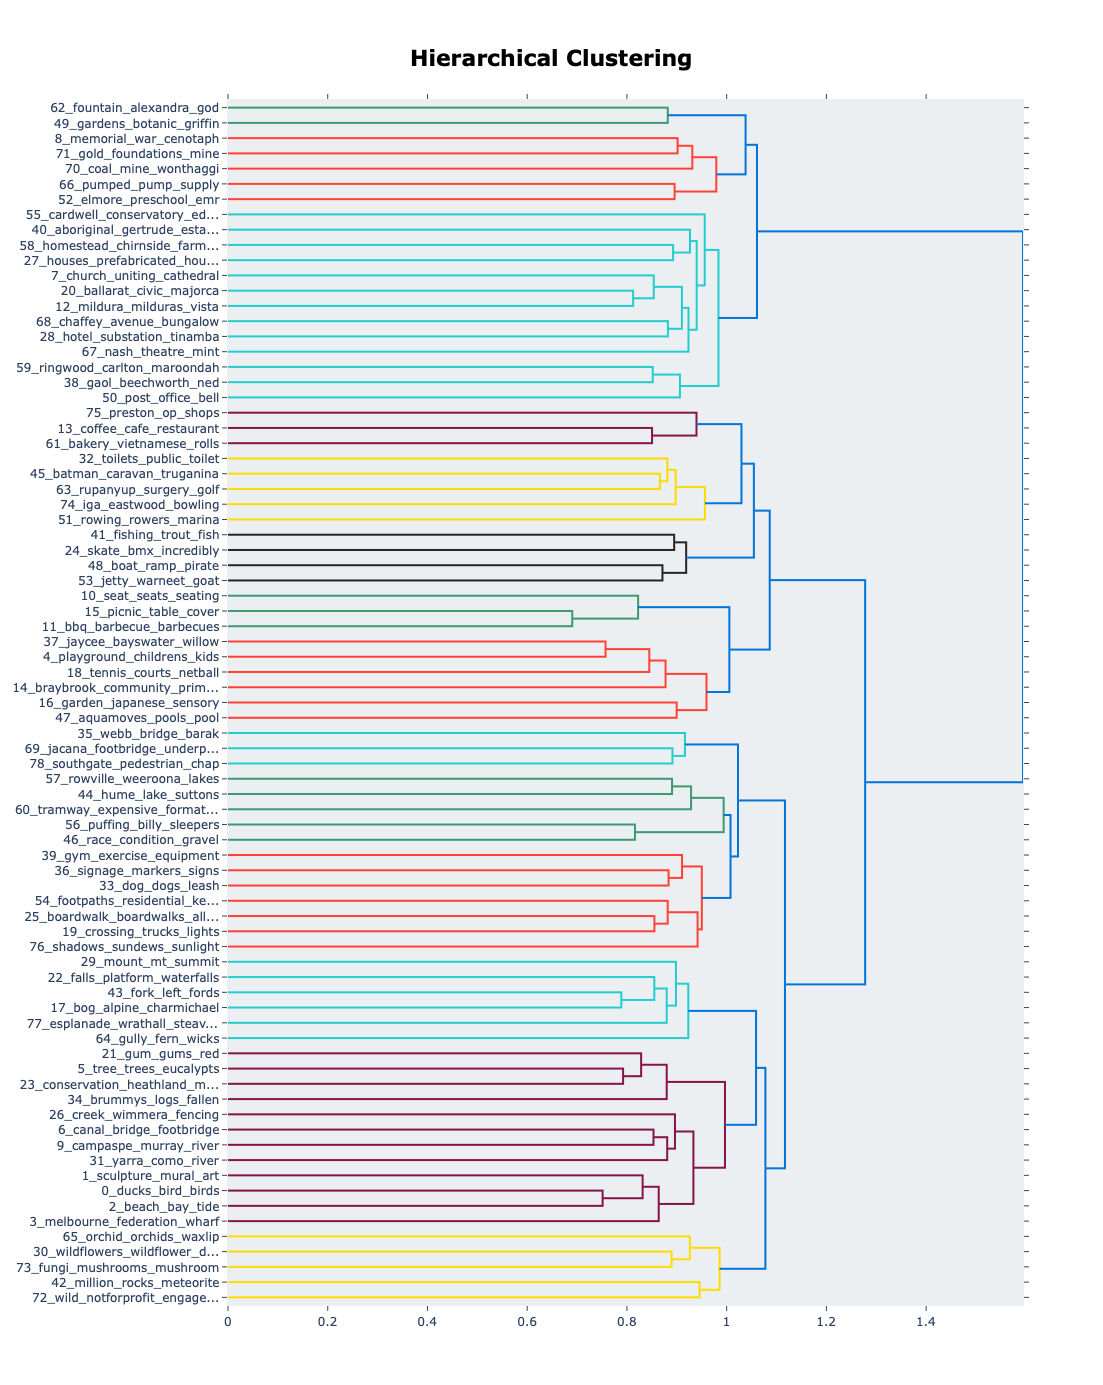

In [18]:
fig = topic_model.visualize_hierarchy()
if os.path.isfile(topic_hierarchy_html_path) and not overwrite:
    logger.info('figure is already saved in HTML and image format')
else:
    fig.write_html(topic_hierarchy_html_path)
    fig.write_image(topic_hierarchy_image_path)
    logger.info(f'figures saved in: \n\t{topic_hierarchy_html_path}\n\t{topic_hierarchy_image_path}')


fig

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 301.65it/s]
2025-01-25 20:17:38.944 | INFO     | __main__:<module>:6 - figures already saved in HTML and image formats


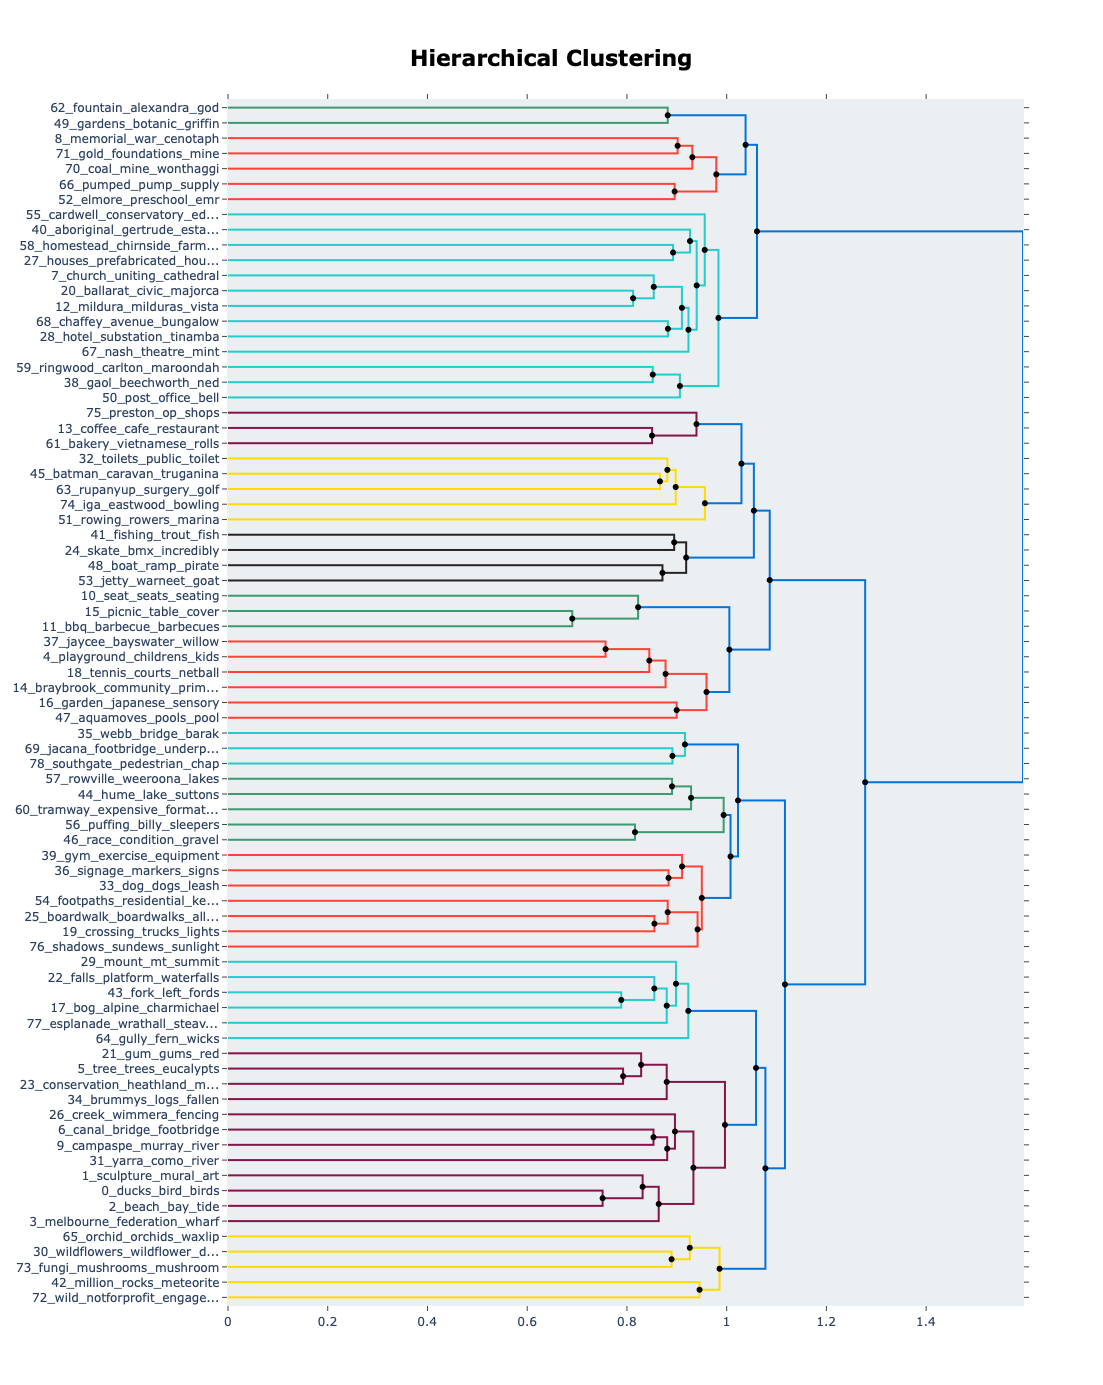

In [19]:
# what happen when merging topics as well
hierarchical_topics = topic_model.hierarchical_topics(docs)
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

if not overwrite and os.path.isfile(detailed_topic_hierarchy_html_path):
    logger.info('figures already saved in HTML and image formats')
else:    
    fig.write_html(detailed_topic_hierarchy_html_path)
    fig.write_image(detailed_topic_hierarchy_image_path)
    logger.info(f'figures saved in: \n\t{detailed_topic_hierarchy_html_path}\n\t{detailed_topic_hierarchy_image_path}')

fig

2025-01-25 20:17:40.147 | INFO     | __main__:<module>:4 - figure is already saved in HTML and image formats


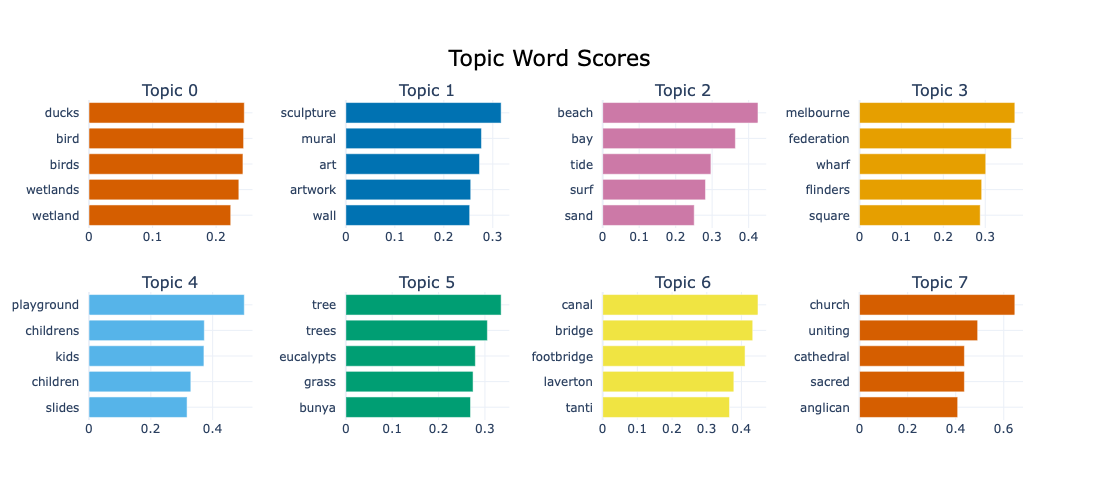

In [20]:
fig = topic_model.visualize_barchart()

if not overwrite and os.path.isfile(barchart_html_path):
    logger.info('figure is already saved in HTML and image formats')
else:
    fig.write_html(barchart_html_path)
    fig.write_image(barchart_image_path)
    logger.info(f'figures saved in: \n\t{barchart_html_path}\n\t{barchart_image_path}')

fig

2025-01-25 20:17:41.001 | INFO     | __main__:<module>:4 - figure is already saved in HTML and image format


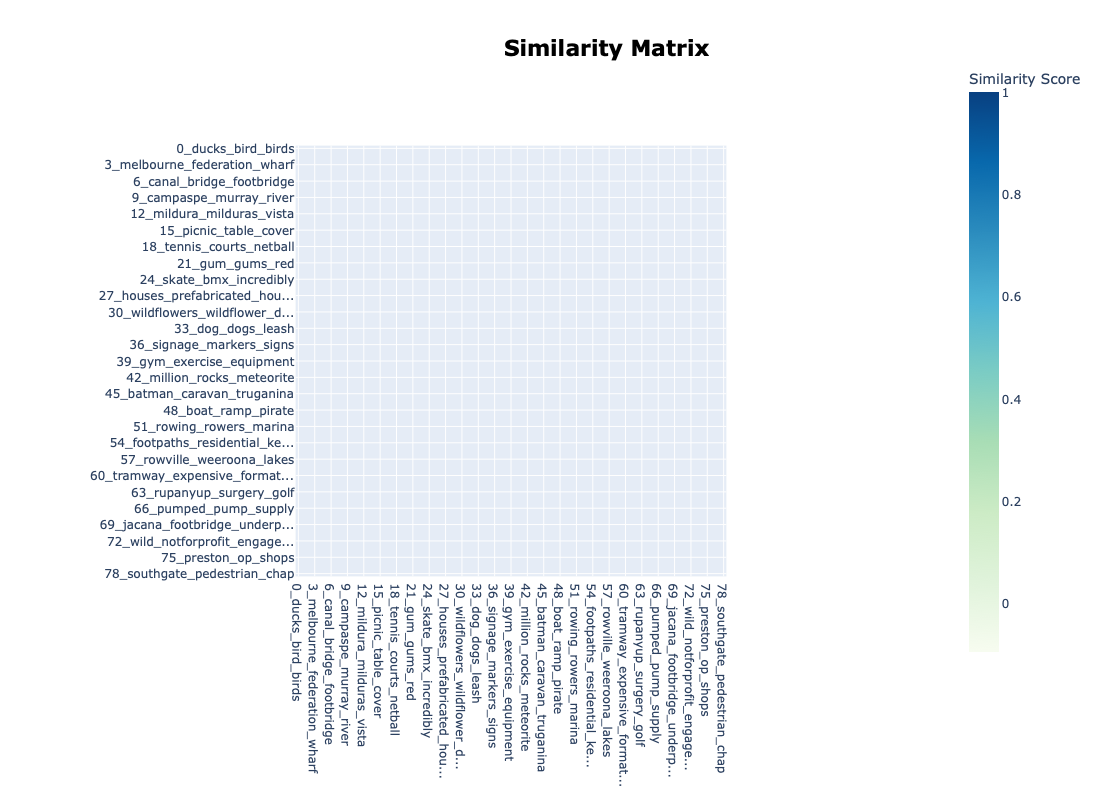

In [21]:
fig = topic_model.visualize_heatmap()

if not overwrite and os.path.isfile(heatmap_html_path):
    logger.info('figure is already saved in HTML and image format')
else:
    fig.write_html(heatmap_html_path)
    fig.write_image(heatmap_image_path)
    logger.info(f'figures saved in: \n\t{heatmap_html_path}\n\t{heatmap_image_path}')

fig

In [22]:
# topic outlier reduction - if necessary (todo)
topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")

In [23]:
topic_df = pd.DataFrame({'topic': topics, 'document': docs})

In [24]:
topic_df.head()

topic                                           document
0      2  Fairhaven Surf Life Saving Club: Fairhaven is ...
1      2  Beach walk: From Sprout Creek, Eastern View, M...
2      0  Rock pools: See what sort of shells and stones...
3      2  Sand dunes: The beautiful rolling sand dunes s...
4     26  Painkalac Creek: The creek separates Aireys In...

In [25]:
topic_df.to_csv('outputs/dataframes/raw-topic-poi-description.csv')

### Conclusions 
Some categories are not atomic, several biases toward famous geographic names including LGAs and suburbs. Removing the geographic names from the POI descriptions will help to understand 'what' categories they belong rather than 'where' they are.

### Refining Topic Models

Due to frequency of famous place names: LGAs and suburbs, several clusters are just defined by their location, while we are more interested to identify their characteristics.

Source:
https://public.opendatasoft.com/explore/dataset/georef-australia-local-government-area/table/?disjunctive.ste_code&disjunctive.ste_name&disjunctive.lga_code&disjunctive.lga_name

https://public.opendatasoft.com/explore/dataset/georef-australia-state-suburb/table/?disjunctive.ste_code&disjunctive.ste_name&disjunctive.lga_code&disjunctive.lga_name&disjunctive.scc_code&disjunctive.scc_name

In [27]:
with open('dataset/georef-australia-state-suburb.json', 'r') as fp:
    suburbs = json.load(fp)
with open('dataset/georef-australia-local-government-area.json', 'r') as fp:
    lgas = json.load(fp)

In [28]:
suburb_names = [suburb['scc_name'][0] for suburb in suburbs]

In [29]:
lga_names = [lga['lga_name'][0] for lga in lgas]

In [30]:
lga_names_lower = [lga.lower() for lga in lga_names]
suburb_names_lower = [suburb.lower() for suburb in suburb_names]

In [31]:
# checking frequent words for place names to filter
description_splits = [s.replace(':', '').split(' ') for s in list(gdf['description'])]
wcounts = {}
for split in description_splits:
    for w in split:
        if w.lower() not in wcounts.keys():
            wcounts[w.lower()] = 0
        wcounts[w.lower()]+=1
sorted_wcounts = {k: v for k, v in sorted(wcounts.items(), key=lambda item: item[1], reverse=True)}


(array([1.3767e+04, 1.9000e+01, 6.0000e+00, 3.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.52066667e+02, 5.03133333e+02, 7.54200000e+02,
        1.00526667e+03, 1.25633333e+03, 1.50740000e+03, 1.75846667e+03,
        2.00953333e+03, 2.26060000e+03, 2.51166667e+03, 2.76273333e+03,
        3.01380000e+03, 3.26486667e+03, 3.51593333e+03, 3.76700000e+03,
        4.01806667e+03, 4.26913333e+03, 4.52020000e+03, 4.77126667e+03,
        5.02233333e+03, 5.27340000e+03, 5.52446667e+03, 5.77553333e+03,
        6.02660000e+03, 6.27766667e+03, 6.52873333e+03, 6.77980000e+03,
        7.03086667e+03, 7.28193333e+03, 7.53300000e+03]),
 <BarContainer object of 30 

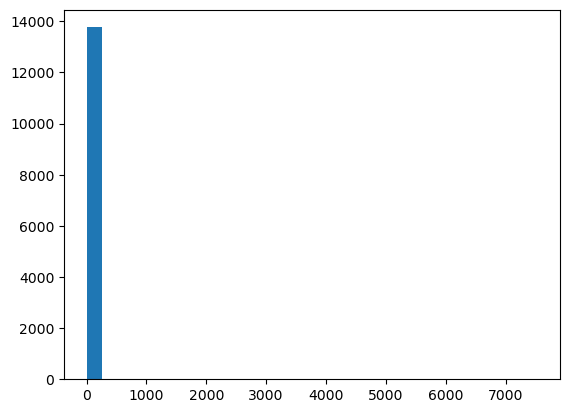

In [32]:
import matplotlib.pyplot as plt

plt.hist(sorted_wcounts.values(), bins=30)

(array([1.3767e+04, 1.9000e+01, 6.0000e+00, 3.0000e+00, 0.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.52066667e+02, 5.03133333e+02, 7.54200000e+02,
        1.00526667e+03, 1.25633333e+03, 1.50740000e+03, 1.75846667e+03,
        2.00953333e+03, 2.26060000e+03, 2.51166667e+03, 2.76273333e+03,
        3.01380000e+03, 3.26486667e+03, 3.51593333e+03, 3.76700000e+03,
        4.01806667e+03, 4.26913333e+03, 4.52020000e+03, 4.77126667e+03,
        5.02233333e+03, 5.27340000e+03, 5.52446667e+03, 5.77553333e+03,
        6.02660000e+03, 6.27766667e+03, 6.52873333e+03, 6.77980000e+03,
        7.03086667e+03, 7.28193333e+03, 7.53300000e+03]),
 <BarContainer object of 30 

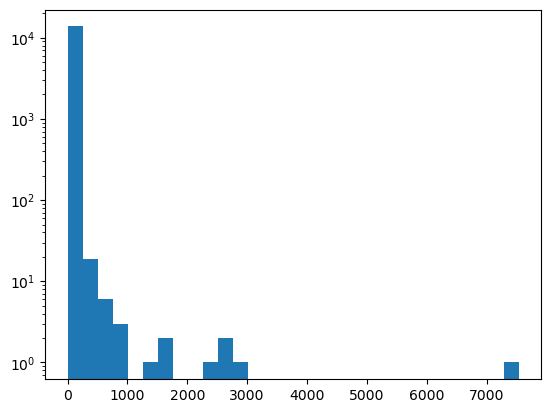

In [33]:
plt.hist(sorted_wcounts.values(), log=True, bins=30)

In [34]:
filtered_words = {k:v for k,v in sorted_wcounts.items() if v >= 10 and v < 50}
logger.info(list(filtered_words.keys()))
logger.info(f'length of selected words for manual check: {len(filtered_words.keys())}')

2025-01-25 20:20:40.023 | INFO     | __main__:<module>:2 - ['children', 'opened', 'perfect', 'established', 'river.', 'skate', 'flora', 'seating', 'nature', 'wetland', 'wall', 'years', 'continue', 'until', 'even', 'located', 'eastern', 'buildings', 'fountain', 'sit', 'family', 'black', 'shopping', 'known', 'wildlife', 'market', 'lookout', 'once', 'museum', 'head', "don't", 'cafe', 'run', 'nice', 'during', 'rock', 'facilities', 'gravel', 'check', 'such', 'plants', 'ducks', 'indigenous', 'national', 'court', 'tower', 'work', 'north', 'how', 'need', 'council', 'while', 'seat', 'bendigo', 'them', 'queen', 'post', 'access', 'come', 'train', 'gum', 'port', 'no', 'visit', 'front', 'wide', 'trees.', 'available', 'high', 'areas', 'species', 'top', 'bush', 'fire', 'section', 'interesting', 'wild', 'valley', 'murray', 'named', 'do', 'west', 'pool', 'sure', 'signs', 'day', 'past', 'always', 'fishing', 'swimming', 'outdoor', 'love', 'shops', 'both', 'bit', 'tennis', "there's", 'birdlife', 'boat', '

In [35]:
filtered_place_names = ['newport', 'Newport', 'collins', 'Collins', 'mildura', 'Mildura', 'esplanade', 'Esplanade',
                        'kensington', 'Kensington', 'australia', 'Australia', 'williamstown', 'Williamstown',
                        'ringwood', 'Ringwood', 'ballarat', 'Ballarat', 'beechworth', 'Beechworth', 'batman', 'Batman',
                        'dandenong', 'Dandenong', 'federation', 'Federation', 'flinders', 'Flinders', 'werribee', 'Werribee',
                        'braybrook', 'Braybrook', 'reservoir', 'Reservoir', 'horsham', 'Horsham', 'mornington', 'Mornington',
                        'bendigo', 'Bendigo', 'cardwell', 'Cardwell', 'st. kilda', 'St. Kilda', 
                        'merri', 'Merri', 'kyneton', 'Kyneton', 'barwon', 'Barwon', 'victoria', 'Victoria', 
                        'darebin', 'Darebin', 'birrarung', 'Birrarung', 'echuca', 'Echuca',
                        'runnymede', 'Runnymede', 'weeroona', 'Weeroona', 'ivanhoe', 'Ivanhoe',
                        'strezlecki', 'Strezlecki', 'balyang', 'Balyang', 'treganowan', 'Treganowan',
                        'wimmera', 'Wimmera', 'altona', 'Altona', 'ferguson', 'Ferguson', 
                        'kathleen', 'Kathleen', 'michie', 'Michie', 'wilkinson', 'Wilkinson', 'recwest', 'Recwest',
                        'rosalind', 'Rosalind', 'narraccan', 'Narraccan', 'ryberg', 'Ryberg', 'iramoo', 'Iramoo', 'narracan', 'Narracan']

In [36]:
import re
from pattern.text.en import singularize

def replace_by_list(desc, names):
    for n in names:
        if n in desc:
            desc = desc.replace(n, '')
    return desc

def refined_description(row):
    desc = row['description']
    desc = replace_by_list(desc, lga_names)
    desc = replace_by_list(desc, lga_names_lower)
    desc = replace_by_list(desc, suburb_names)
    desc = replace_by_list(desc, filtered_place_names)
    desc = replace_by_list(desc, suburb_names_lower)
    desc = re.sub('[0-9]', '', desc)  # remove numbers
    return ' '.join([singularize(token) for token in desc.split()])

In [37]:
gdf['refined_description'] = gdf.apply(refined_description, axis=1)

In [38]:
gdf.head()

poi_title  \
0  Fairhaven Surf Life Saving Club   
1                       Beach walk   
2                       Rock pools   
3                       Sand dunes   
4                  Painkalac Creek   

                                         poi_summary   latitude   longitude  \
0  Fairhaven is a well known surf beach. The beac... -38.468759  144.084459   
1  From Sprout Creek, Eastern View, Moggs Creek, ... -38.468542  144.089693   
2  See what sort of shells and stones you can col... -38.468459  144.092420   
3  The beautiful rolling sand dunes shape the bea... -38.468418  144.095318   
4  The creek separates Aireys Inlet from Fairhave... -38.468390  144.097312   

                      geometry  \
0  POINT (144.08446 -38.46876)   
1  POINT (144.08969 -38.46854)   
2  POINT (144.09242 -38.46846)   
3  POINT (144.09532 -38.46842)   
4  POINT (144.09731 -38.46839)   

                                         description  \
0  Fairhaven Surf Life Saving Club: Fairhaven is ...   
1  Beach walk: From Sprout Creek, Eastern View, M...   
2  Rock pools: See what sort of shells and stones...   
3  Sand dunes: The beautiful rolling sand dunes s...   
4  Painkalac Creek: The creek separates Aireys In...   

                                 refined_description  
0  Surf Life Saving Club: is a well known surf be...  
1  Beach walk: From Sprout Creek, , , to the bott...  
2  Rock pools: See what sort of shell and stone y...  
3  Sand dunes: The beautiful rolling sand dune sh...  
4  Painkalac Creek: The creek sete from and form ...

In [39]:
refined_docs = list(gdf['refined_description'])

refind_model_path = 'outputs/model/refined_poi_descriptions'

if os.path.isfile(refind_model_path) and not overwrite:
    logger.info('loading refined model from outputs folder')
    refined_topic_model = BERTopic.load(refind_model_path)
    refined_topics = refined_topic_model.topics_
    refined_probs = refined_topic_model.probabilities_
    logger.info('The refined model from outputs folder is loaded')
else:
    logger.info('A refined model not found in the outputs folder')
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    refined_topic_model = BERTopic(umap_model=umap_model, ctfidf_model=ctfidf_model)
    refined_topics, refined_probs = refined_topic_model.fit_transform(refined_docs)
    refined_topic_model.save(refind_model_path, serialization='pickle')
    logger.info('saving refined model from outputs folder')

2025-01-25 20:21:09.736 | INFO     | __main__:<module>:6 - loading refined model from outputs folder
2025-01-25 20:21:11.184 | INFO     | __main__:<module>:10 - The refined model from outputs folder is loaded


In [40]:
refined_topic_info = refined_topic_model.get_topic_info()
refined_topic_info.to_csv('outputs/dataframes/refined-topic.csv')

In [41]:
experiment_name = 'refined-poi'

intertopic_distance_map_html_path = f'outputs/figure/intertopic-dmap-{experiment_name}.html'
intertopic_distance_map_image_path = f'outputs/figure/intertopic-dmap-{experiment_name}.png'

topic_hierarchy_html_path = f'outputs/figure/topic-hierarchy-{experiment_name}.html'
topic_hierarchy_image_path = f'outputs/figure/topic-hierarchy-{experiment_name}.png'

detailed_topic_hierarchy_html_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.html'
detailed_topic_hierarchy_image_path = f'outputs/figure/detailed-topic-hierarchy-{experiment_name}.png'

barchart_html_path = f'outputs/figure/barchart-{experiment_name}.html'
barchart_image_path = f'outputs/figure/barchart-{experiment_name}.png'

heatmap_html_path = f'outputs/figure/heatmap-{experiment_name}.html'
heatmap_image_path = f'outputs/figure/heatmap-{experiment_name}.png'

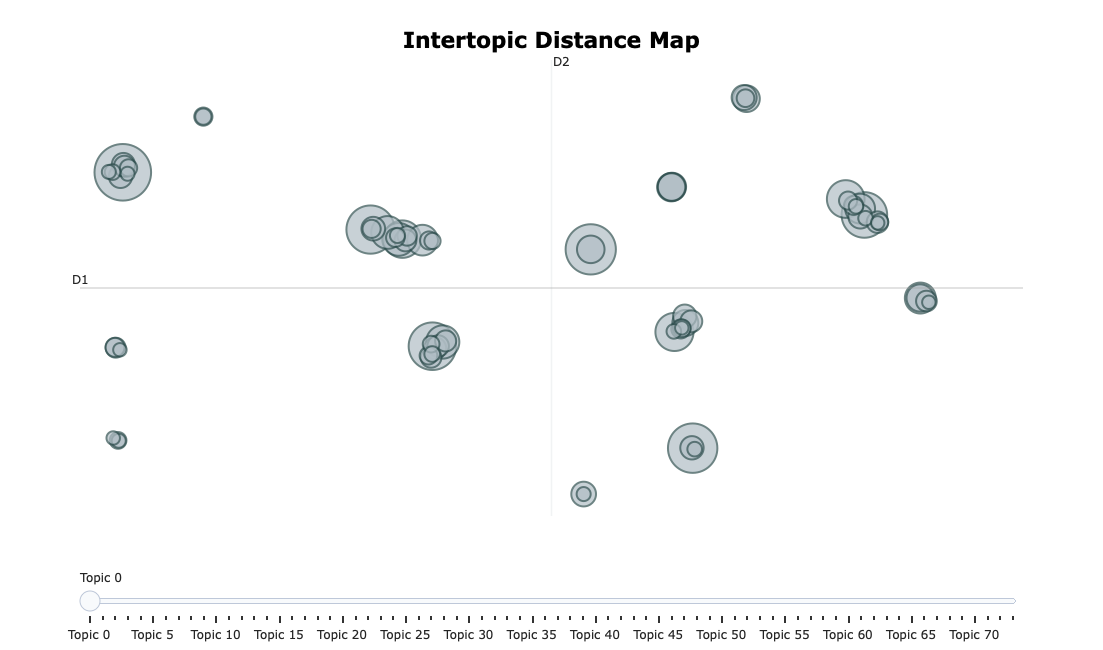

In [42]:
fig = refined_topic_model.visualize_topics()
if overwrite:
    fig.write_html(intertopic_distance_map_html_path)
    fig.write_image(intertopic_distance_map_image_path)
    logger.info('saving refined model results')

fig

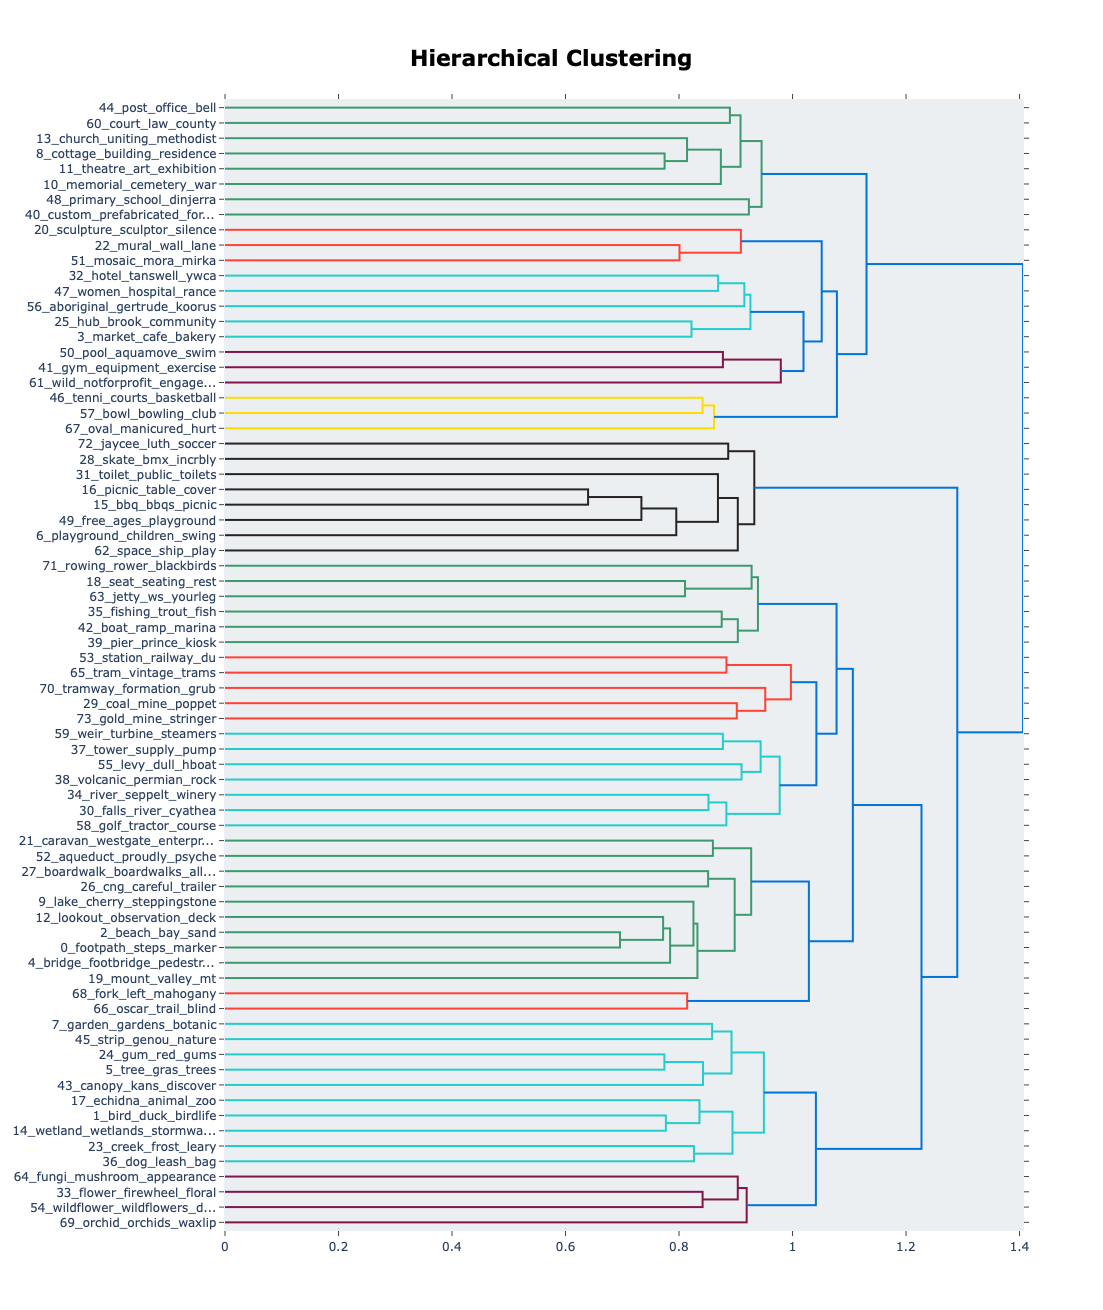

In [43]:
fig = refined_topic_model.visualize_hierarchy()
if overwrite:
    logger.info('saving refined model results')
    fig.write_html(topic_hierarchy_html_path)
    fig.write_image(topic_hierarchy_image_path)

fig

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 306.82it/s]


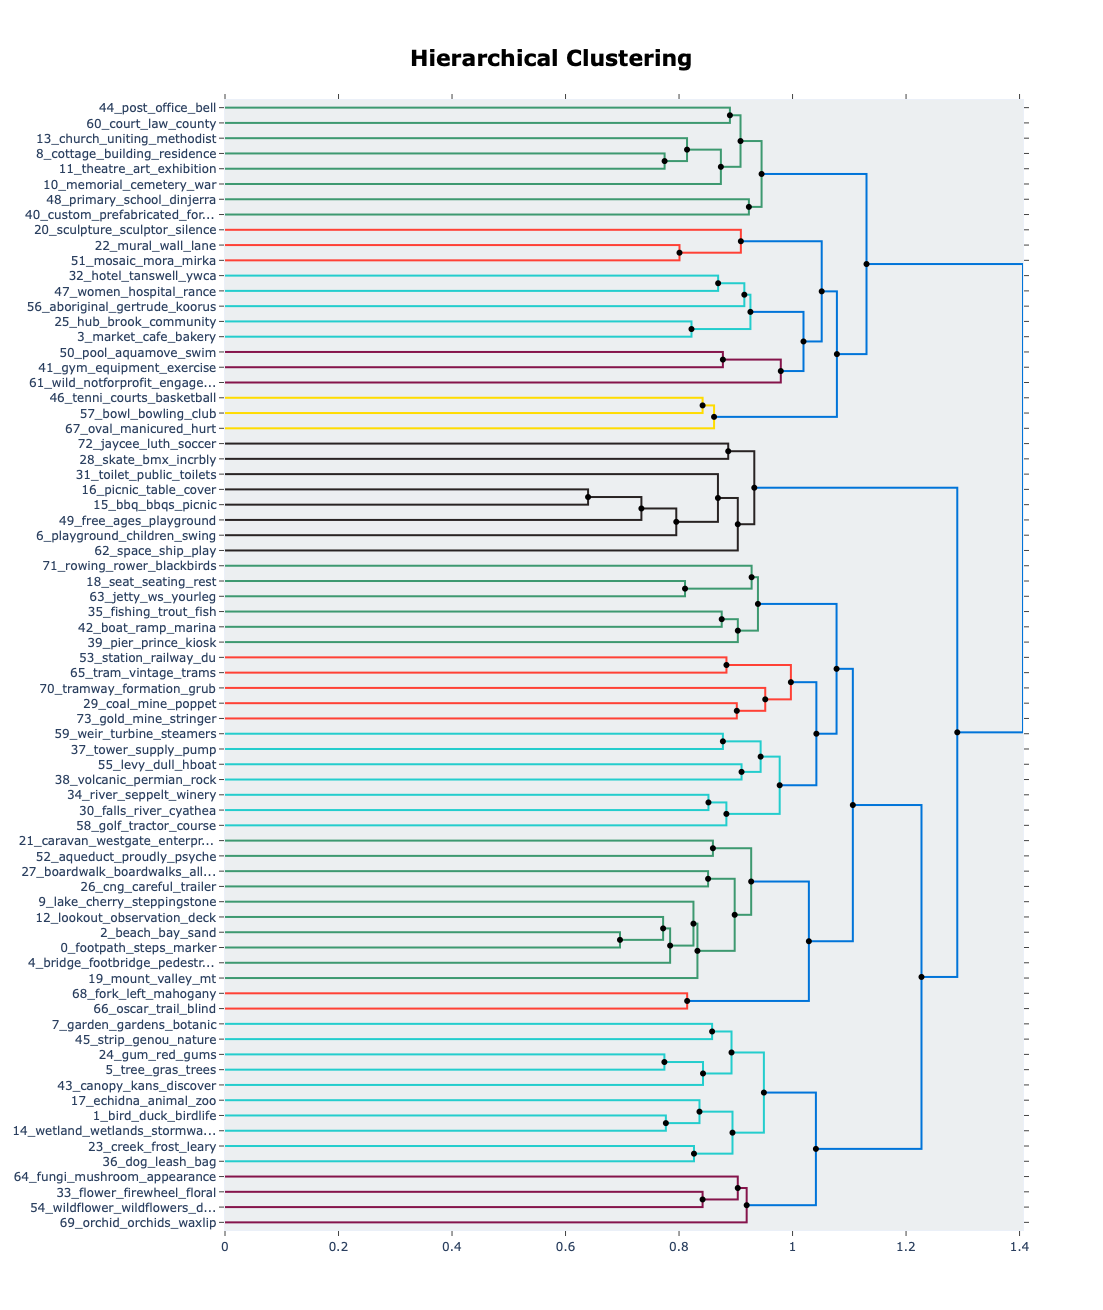

In [44]:
# what happen when merging topics as well
hierarchical_refined_topics = refined_topic_model.hierarchical_topics(refined_docs)
fig = refined_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_refined_topics)
if overwrite:
    logger.info('saving refined model results')
    fig.write_html(detailed_topic_hierarchy_html_path)
    fig.write_image(detailed_topic_hierarchy_image_path)

fig

In [45]:
# topic outlier reduction - if necessary (todo)
refined_topics = refined_topic_model.reduce_outliers(refined_docs, refined_topics, strategy="c-tf-idf")

refined_topic_df = pd.DataFrame({'topic': refined_topics, 'document': refined_docs})

In [46]:
refined_topic_df.to_csv('outputs/dataframes/refined-topic-poi-description.csv')

In [47]:
n_unique_refiend_topics = len(set(refined_topics))
n_unique_refiend_topics

75

In [48]:
refined_topic_df

topic                                           document
0         2  Surf Life Saving Club: is a well known surf be...
1         2  Beach walk: From Sprout Creek, , , to the bott...
2         1  Rock pools: See what sort of shell and stone y...
3         2  Sand dunes: The beautiful rolling sand dune sh...
4        23  Painkalac Creek: The creek sete from and form ...
...     ...                                                ...
4387      5  Lot of native flora: There are many native tre...
4388      0  Continue the loop or go elsewhere: There are p...
4389      0  Residential Street: Thi section of the walk ta...
4390      6  The Stable Playground: Thi playground is huge ...
4391     18  Plenty of seats: There are plenty of seat alon...

[4392 rows x 2 columns]

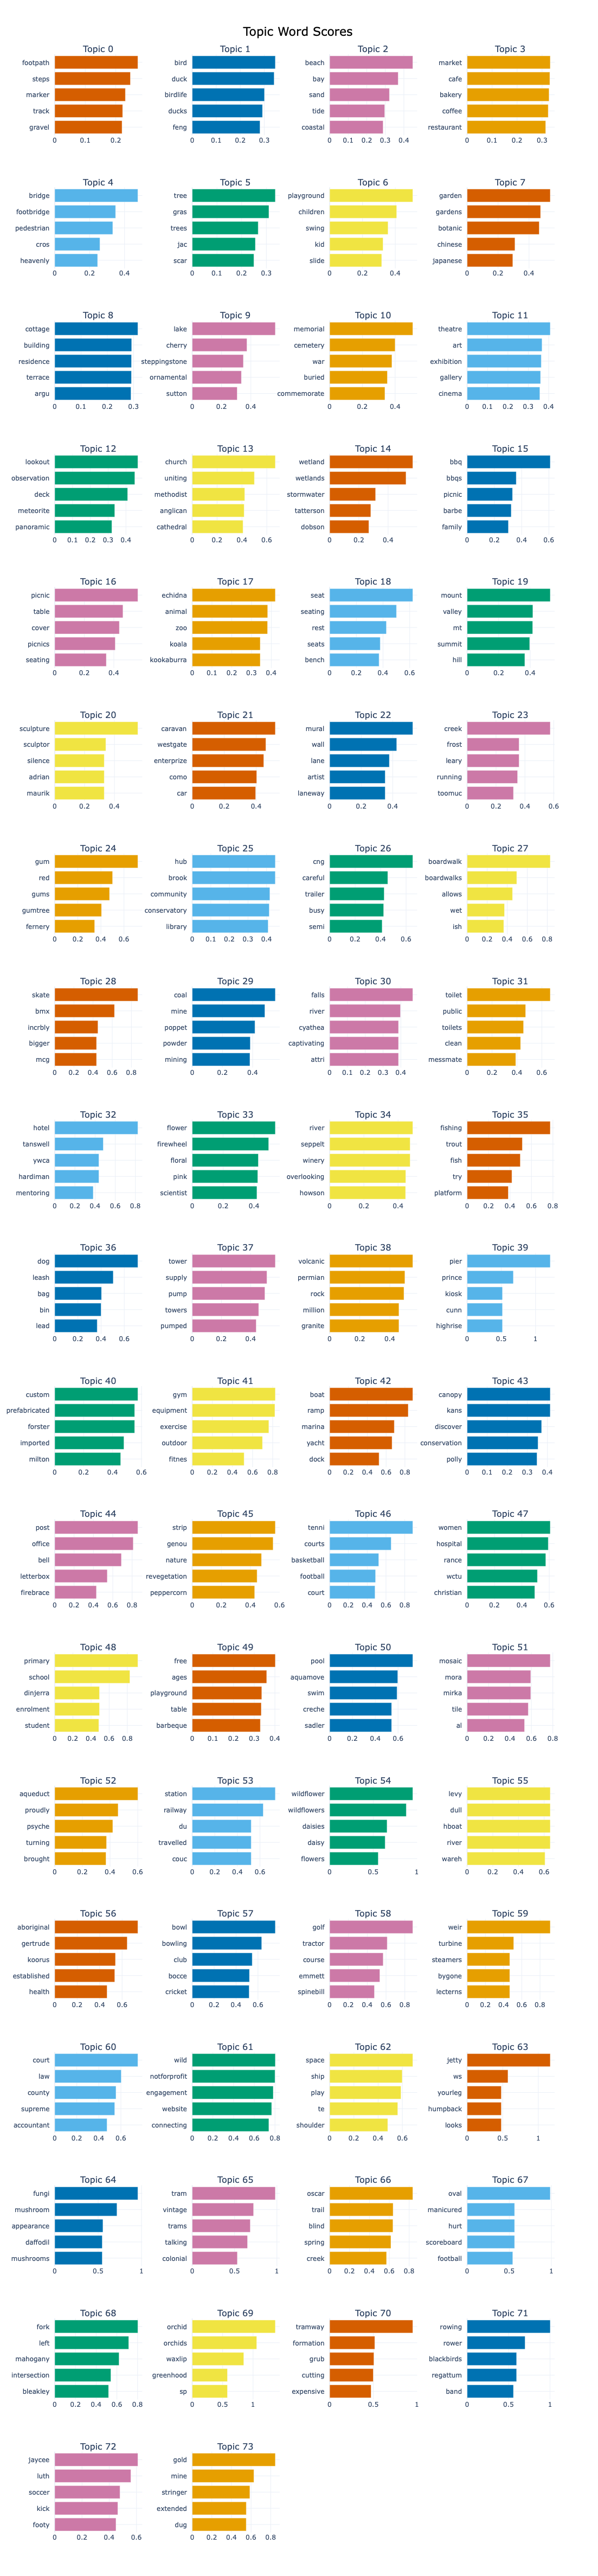

In [50]:

fig = refined_topic_model.visualize_barchart(top_n_topics=n_unique_refiend_topics)
if overwrite:
    logger.info('saving refined model results')
    fig.write_html(barchart_html_path)
    fig.write_image(barchart_image_path)

fig

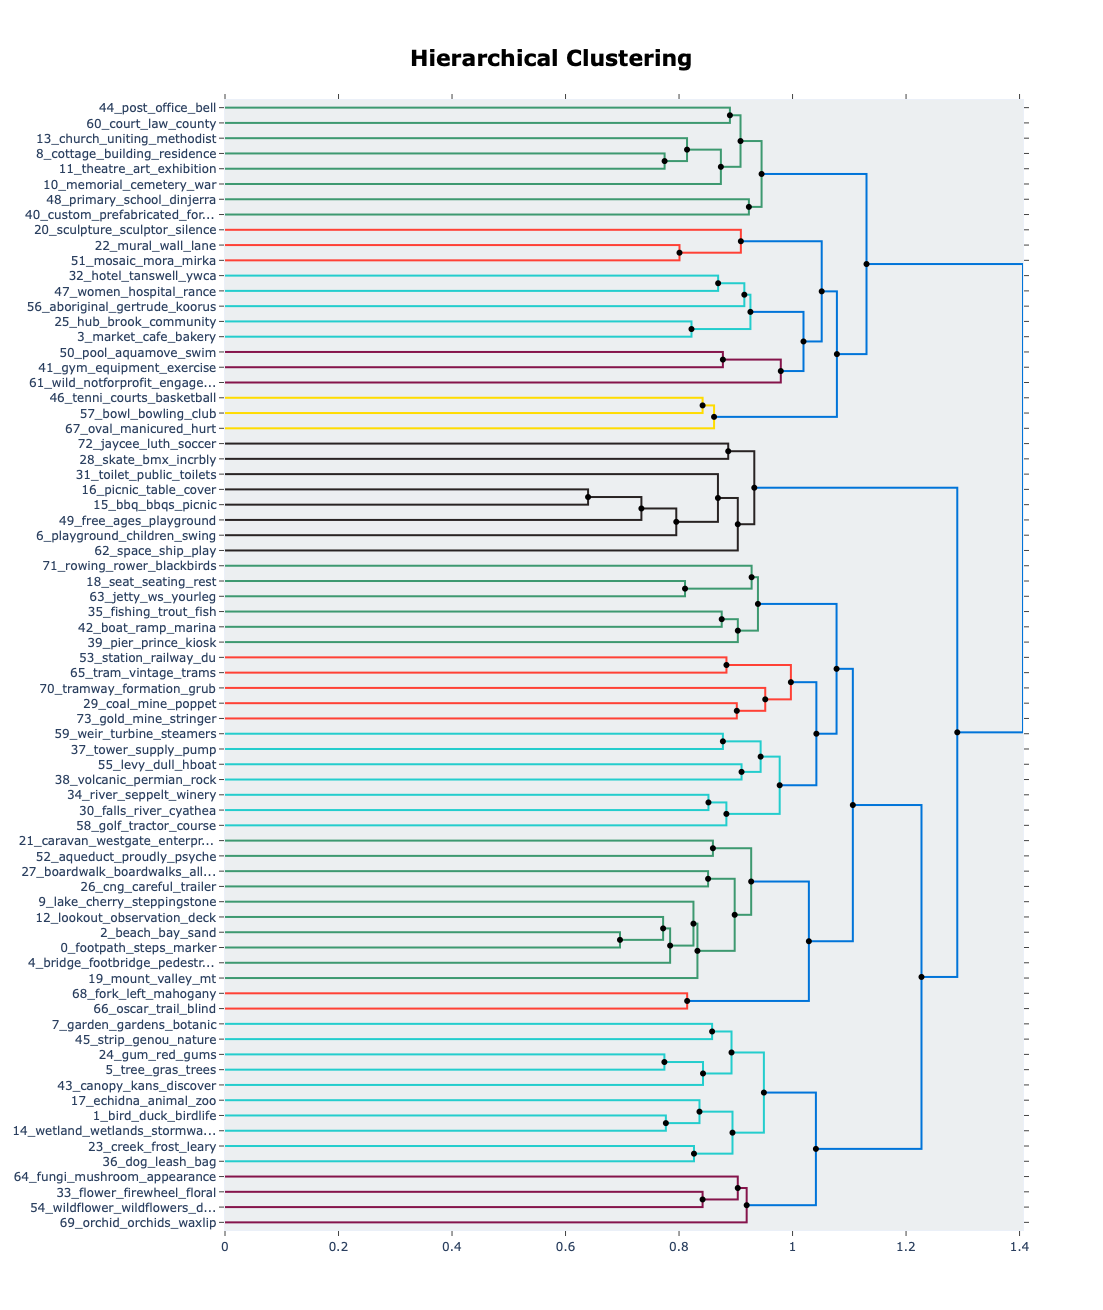

In [51]:
refined_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_refined_topics)

In [52]:
labelled_topics = {'0_nature_flora and funa': [1,5,17,24,33,43,45,54,63,64,69,61],
                   '0_nature_natural landmarks': [2,9,12,14,19,23,30,34,66,38], 

                   '1_activities_fishing to surfing': [35,42,50,55,71,39,59],
                   '1_activities_picnic_camping': [6,15,16,18,21,31,49],
                   '1_activities_food and beverage': [3],
                   '1_activities_sport complexes': [28,41,46,57,58,67,72],

                   '2_society_human made landmarks': [7,11,32,44,47,48,60], 
                   '2_society_art, history and culture': [8,10,13,20,22,29,37,40,51,56,65,73,25,52],

                   '3_transport_trail-path-and-canal': [0,4,27],
                   '3_transport_lines and stations': [53,70],
                   
                   '4_unknown_unknown': [-1,26,36,62,68]
}

In [53]:
sum([len(labelled_topics[key]) for key in labelled_topics.keys()])

75

In [54]:
def labelled_stats(topic_ids, labelled_topics = labelled_topics):
    stat_topics = {}
    for idx in topic_ids:
        for key, values in labelled_topics.items():
            if idx in values:
                if key not in stat_topics.keys():
                    stat_topics[key] = 1
                else:
                    stat_topics[key] += 1
    return stat_topics

In [55]:
def label_topic_func(row):
    topic_id = int(row['Topic'])
    for key, ids in labelled_topics.items():
        if topic_id in ids:
            key_split = key.split('_')
            row['Class ID'] = int(key_split[0])
            row['Class'] = key_split[1]
            row['Subclass'] = key_split[2]
    return row

In [56]:
refined_topic_info = refined_topic_info.apply(label_topic_func, axis=1)
refined_topic_info.to_csv('outputs/dataframes/refined-topics-classified.csv')

In [57]:
refined_topic_info

Topic  Count                                 Name  \
0      -1   1454           -1_reserve_back_track_sign   
1       0    194        0_footpath_steps_marker_track   
2       1    153           1_bird_duck_birdlife_ducks   
3       2    148                2_beach_bay_sand_tide   
4       3    141          3_market_cafe_bakery_coffee   
..    ...    ...                                  ...   
70     69     11   69_orchid_orchids_waxlip_greenhood   
71     70     11    70_tramway_formation_grub_cutting   
72     71     11  71_rowing_rower_blackbirds_regattum   
73     72     11           72_jaycee_luth_soccer_kick   
74     73     11       73_gold_mine_stringer_extended   

                                       Representation  \
0   [reserve, back, track, sign, up, after, rail, ...   
1   [footpath, steps, marker, track, gravel, path,...   
2   [bird, duck, birdlife, ducks, feng, hide, nest...   
3   [beach, bay, sand, tide, coastal, coast, patro...   
4   [market, cafe, bakery, coffee, restaurant, sho...   
..                                                ...   
70  [orchid, orchids, waxlip, greenhood, sp, noddi...   
71  [tramway, formation, grub, cutting, expensive,...   
72  [rowing, rower, blackbirds, regattum, band, mi...   
73  [jaycee, luth, soccer, kick, footy, circus, pi...   
74  [gold, mine, stringer, extended, dug, foundati...   

                                  Representative_Docs  Class ID       Class  \
0   [Nature at it finest: The path is edged by bea...         4     unknown   
1   [While the car slog away above it peaceful dow...         3   transport   
2   [Black s: Keep an eye out for the birdlife at ...         0      nature   
3   [Apollo Bay beach: The beach is most sheltered...         0      nature   
4   [General Store & Meikle' Pub: The store ha gou...         1  activities   
..                                                ...       ...         ...   
70  [Nodding Greenhood Orchid: These beautiful orc...         0      nature   
71  [incline tramway: Thi is the only incline fire...         3   transport   
72  [Rowing: Walk past the rowing sheds. Lot of ac...         1  activities   
73  [Norman Luth Reserve: Norman Luth Reserve is a...         1  activities   
74  [Mining Race: Thi tailrace wa cut through soli...         2     society   

                    Subclass  
0                    unknown  
1       trail-path-and-canal  
2             flora and funa  
3          natural landmarks  
4          food and beverage  
..                       ...  
70            flora and funa  
71        lines and stations  
72        fishing to surfing  
73           sport complexes  
74  art, history and culture  

[75 rows x 8 columns]

In [58]:
refined_topic_df

index  topic                                           document
0         0      2  Surf Life Saving Club: is a well known surf be...
1         1      2  Beach walk: From Sprout Creek, , , to the bott...
2         2      1  Rock pools: See what sort of shell and stone y...
3         3      2  Sand dunes: The beautiful rolling sand dune sh...
4         4     23  Painkalac Creek: The creek sete from and form ...
...     ...    ...                                                ...
4387   4387      5  Lot of native flora: There are many native tre...
4388   4388      0  Continue the loop or go elsewhere: There are p...
4389   4389      0  Residential Street: Thi section of the walk ta...
4390   4390      6  The Stable Playground: Thi playground is huge ...
4391   4391     18  Plenty of seats: There are plenty of seat alon...

[4392 rows x 3 columns]

In [59]:
refined_topic_poi_description = pd.merge(refined_topic_df, refined_topic_info, left_on='topic', right_on='Topic', how='inner').drop('Topic', axis=1)
refined_topic_poi_description.to_csv('outputs/dataframes/refined-topic-poi-description-classified.csv')